In [1]:
import math
import random
import time
from jupyterthemes import jtplot
jtplot.style()

import gym
gym.logger.set_level(40)
import numpy as np


import nnabla as nn
import nnabla.logger as logger
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solver as S
from nnabla.contrib.context import extension_context
from nnabla.monitor import Monitor, MonitorSeries, MonitorTimeElapsed

2018-08-12 12:11:12,036 [nnabla][INFO]: Initializing CPU extension...


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [4]:
from collections import deque
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [17]:
env = gym.make("CartPole-v0")
state_num = env.observation_space.shape[0]
action_num = env.action_space.n
hidden_size = 128
max_frames = 2000
state_size = 1
batch_size = 32
replay_buffer_size = 1000
gamma = 0.99
learning_rate = 1e-3

In [7]:
def DQN(state):
    with nn.parameter_scope("DQN"):
        with nn.parameter_scope("affine1"):
            h = F.relu(PF.affine(state, hidden_size))
        with nn.parameter_scope("affine2"):
            h = F.relu(PF.affine(h, hidden_size))
        with nn.parameter_scope("affine3"):
            Q = PF.affine(h, action_num)
    return Q

def act(state, epsilon):
    if random.random() > epsilon:
        State.d = state
        Q.forward()
        action  = np.argmax(Q.d)
#        print("q_value.d",Q.d[0])
    else:
        action = random.randrange(action_num)
    return action

In [8]:
replay_buffer = ReplayBuffer(replay_buffer_size)

#変数定義
State = nn.Variable([32, 4]) #あとで次元数変数で定義
Action = nn.Variable([32, 1])
Q = DQN(State)
Q_value = F.sum(F.one_hot(Action, (2,)) * Q, axis=1, keepdims=True)#QからActionのやつを抜き出す
t = nn.Variable([32, 1])
#t = nn.Variable([32, 2])

#損失関数定義
loss = F.squared_error(Q_value, t)

#solver定義
solver = S.Adam(learning_rate)
with nn.parameter_scope("DQN"):
    solver.set_parameters(nn.get_parameters())
solver.zero_grad()

losses = []
overall_rewards = []
episode_reward = 0

In [12]:
def compute_td_loss(batch_size):
    global State, Q, t, loss
    #リプレイサンプル
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    #変数代入
    State.d = state
    
    #行動の次元数が1のとき
    action = np.array(action)
    action = action.reshape([batch_size,1])
    Action.d = action
    
    Q.forward()
    Q_value.forward()
    t.d = np.full((32,1),-100.0)
    
    loss.forward()
    solver.zero_grad()
    loss.backward()
    solver.update()
#    print("DQN_loss",loss.d)
#    Q = DQN(State)
#    print("Q1 :",Q.d)
#    Q.forward()
#    print("action :",Action.d)
#    print("Q2 :",Q.d)
    return loss
"""
    q_values = DQN(State)
    q_values = np.array([q_values.d[i,action[i]] for i in range(batch_size)])
    next_q_values = DQN(Next_State)
    next_q_values = next_q_values.d.max(axis=1)
    reward = np.array(reward)
    done = np.array(done)
    expected_q_value = reward + gamma * next_q_values * (1 - done)
    q_values = nn.Variable.from_numpy_array(q_values)
    expected_q_value = nn.Variable.from_numpy_array(expected_q_value)

    DQN_loss = F.squared_error(q_values, expected_q_value)
    DQN_loss.forward()
    DQN_solver.zero_grad()
    DQN_loss.backward()
    DQN_solver.update()
"""

'\n    q_values = DQN(State)\n    q_values = np.array([q_values.d[i,action[i]] for i in range(batch_size)])\n    next_q_values = DQN(Next_State)\n    next_q_values = next_q_values.d.max(axis=1)\n    reward = np.array(reward)\n    done = np.array(done)\n    expected_q_value = reward + gamma * next_q_values * (1 - done)\n    q_values = nn.Variable.from_numpy_array(q_values)\n    expected_q_value = nn.Variable.from_numpy_array(expected_q_value)\n\n    DQN_loss = F.squared_error(q_values, expected_q_value)\n    DQN_loss.forward()\n    DQN_solver.zero_grad()\n    DQN_loss.backward()\n    DQN_solver.update()\n'

In [13]:
def plot(frame, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

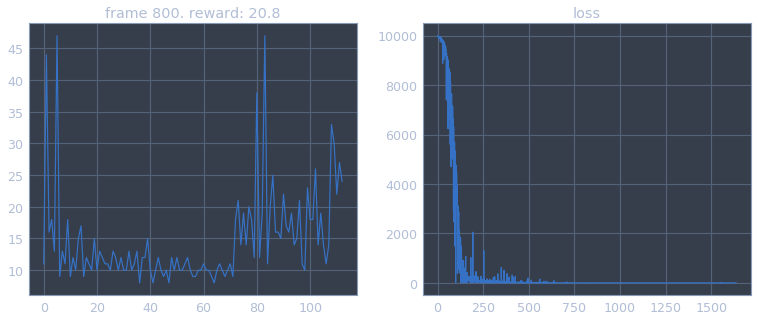

[[ -99.80424   -99.87024 ]
 [ -99.91083   -99.976265]
 [ -99.92907  -100.06729 ]
 [ -99.92564  -100.03492 ]
 [ -99.89469  -100.05876 ]
 [-100.15935  -100.41759 ]
 [-100.13561  -100.24519 ]
 [ -99.81894   -99.938614]
 [-100.10336  -100.146416]
 [ -99.98337   -99.88798 ]
 [ -99.94496  -100.11498 ]
 [ -99.8985    -99.9258  ]
 [-100.18402  -100.151695]
 [ -99.77461   -99.82689 ]
 [-100.51336   -99.684845]
 [-100.001564  -99.99009 ]
 [-100.209625 -100.29892 ]
 [-100.115166 -100.112915]
 [-100.020836  -99.58776 ]
 [ -99.94229   -99.894066]
 [ -99.92683   -99.93063 ]
 [ -99.939415 -100.01467 ]
 [-100.121315 -100.38652 ]
 [ -99.9179    -99.924835]
 [-100.05651  -100.18271 ]
 [ -99.98174  -100.08201 ]
 [-100.00157  -100.15148 ]
 [ -99.99802  -100.015724]
 [ -99.87953   -99.90222 ]
 [-100.19286  -100.219154]
 [ -99.91318  -100.0738  ]
 [ -99.55357   -99.59039 ]]
[[ -99.80424 ]
 [ -99.91083 ]
 [ -99.92907 ]
 [ -99.92564 ]
 [-100.05876 ]
 [-100.41759 ]
 [-100.13561 ]
 [ -99.938614]
 [-100.10336 ]


KeyboardInterrupt: 

In [14]:
state = env.reset()
nn.clear_parameters()
for frame in range(1, max_frames):
    epsilon = epsilon_by_frame(frame)
    action = act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward   
#    env.render()
    if done:
        state = env.reset()
        overall_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(np.average(loss.d[0]))
    if frame % 200 == 0:
        plot(frame, overall_rewards, losses)

In [ ]:
a = np.ndarray([4,1])
b = np.ndarray([4])
b = b.reshape([4,1])

print(a)
print(b)